[Vader Score Explanations](https://github.com/cjhutto/vaderSentiment)

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

* positive sentiment: compound score >= 0.05
* neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
* negative sentiment: compound score <= -0.05


The pos, neu, and neg scores are ratios for proportions of text that fall in each category (so these should all add up to be 1... or close to it with float operation). These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.

[textblob](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis)

The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

# Start Spark

In [1]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer    

In [2]:
# note: you need to do the following:
# export PYSPARK_PYTHON=/home/jeroens/miniconda3/envs/pyspark/bin
# the direcotry of your pyspark kernel so that spark can hit the vader library in the udf

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, MapType, FloatType

In [4]:
spark = SparkSession.builder\
                        .master("local[*]")\
                        .config('spark.executor.memory', '5g')\
                        .config('spark.driver.memory', '5g')\
                    .appName("Sentiment Analysis")\
                    .getOrCreate()
spark

# Twitter

## ETH

In [5]:
parquet_eth_path = "../data/tweets/ethereum/parquet/sentiment/"
eth = spark.read.parquet(parquet_eth_path)

In [6]:
eth.printSchema()

root
 |-- username: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- text: string (nullable = true)
 |-- retweets: integer (nullable = true)
 |-- favorites: integer (nullable = true)
 |-- geo: string (nullable = true)
 |-- mentions: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- pos_vader: float (nullable = true)
 |-- neg_vader: float (nullable = true)
 |-- neu_vader: float (nullable = true)
 |-- compound_vader: float (nullable = true)
 |-- polarity_textblob: float (nullable = true)
 |-- subjectivity_textblob: float (nullable = true)



In [10]:
eth_summary = eth.select("datetime",
                        "retweets",
                         "favorites",
                         "pos_vader",
                         "neg_vader",
                         "neu_vader",
                         "compound_vader",
                         "polarity_textblob",
                         "subjectivity_textblob")\
                            .summary().toPandas()

In [11]:
eth_summary

,summary,retweets,favorites,pos_vader,neg_vader,neu_vader,compound_vader,polarity_textblob,subjectivity_textblob
0,count,4326320,4326320,4326193,4326193,4326193,4326193,4326193,4326193
1,mean,4.185458310989478,4.360915743634313,0.06594092441534928,0.019810879483277526,0.9142425385250046,0.12766594645681872,0.09602870237467225,0.2340603381160907
2,stddev,68.76365700629094,61.61669243516935,0.10842246666342376,0.05943834623232154,0.12085496006254005,0.3160192035238254,0.21948549527463967,0.29145384865587975
3,min,0,0,0.0,0.0,0.0,-0.9972,-1.0,0.0
4,25%,0,0,0.0,0.0,0.844,0.0,0.0,0.0
5,50%,0,0,0.0,0.0,1.0,0.0,0.0,0.0
6,75%,0,1,0.122,0.0,1.0,0.34,0.16666667,0.45625
7,max,19143,13843,1.0,1.0,1.0,0.9918,1.0,1.0


In [24]:
from pyspark.sql.functions import min, max

eth.withColumn('date',date_format('datetime','yyyy-MM-dd'))\
.select(min("date"),max("date")).show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2016-01-01|2018-05-30|
+----------+----------+



In [12]:
from pyspark.sql.functions import col,date_format,avg, col, count, when
daily_sentiment_avg = eth.withColumn('date',date_format('datetime','yyyy-MM-dd'))\
.groupby('date')\
.agg(
avg("pos_vader"),
avg("neg_vader"),
avg("neu_vader"),
avg("compound_vader"),
avg("polarity_textblob"),
avg("subjectivity_textblob"),
count(when(col("compound_vader") > 0.5, col("compound_vader"))).alias("negative"),
count(when(col("compound_vader") < -0.5, col("compound_vader"))).alias("positive"),
)\
.withColumn(
            "month",
            date_format('date','yyyy-MM')
            )\
.withColumn(
            "neg/pos ratio",
            col("negative")/col("positive")
            )\
.drop("negative","positive")

In [13]:
eth.withColumn(
            "month",
            date_format('datetime','yyyy-MM')
            )\
    .filter("month > '2017-06'")\
    .groupBy("month")\
    .count()\
    .sort("month")\
    .show()

+-------+------+
|  month| count|
+-------+------+
|2017-07|165057|
|2017-08|157297|
|2017-09|161489|
|2017-10|189954|
|2017-11|225186|
|2017-12|263108|
|2018-01|385561|
|2018-02|336149|
|2018-03|528016|
|2018-04|507913|
|2018-05|535153|
+-------+------+



In [14]:
# takes some time
eth_tweets_ss = eth.withColumn(
            "month",
            date_format('datetime','yyyy-MM')
            )\
    .filter("month > '2017-12'")\
    .toPandas()

In [15]:
eth_tweets_ss

,username,datetime,text,retweets,favorites,geo,mentions,hashtags,id,permalink,pos_vader,neg_vader,neu_vader,compound_vader,polarity_textblob,subjectivity_textblob,month
0,Booleano101,2018-02-13 23:51:00,ethereum is better technology with more applic...,0,0,None,None,None,963561344476827648,https://twitter.com/Booleano101/status/9635613...,0.225,0.000,0.775,0.7003,0.375000,0.400000,2018-02
1,celilozturk24,2018-02-13 23:47:00,#Airdrop #live #Token #Ethereum #Giveaway #cry...,0,0,None,@cheche229 @I_Demonangel @maye5104,#Airdrop #live #Token #Ethereum #Giveaway #cry...,963560386392985600,https://twitter.com/celilozturk24/status/96356...,0.000,0.000,1.000,0.0000,0.268182,0.650000,2018-02
2,CryptoWiesiek,2018-02-13 23:45:00,Another interesting ICO on the line #TokenSale...,0,0,None,None,#TokenSale #Ethereum #LiveTreeADEPT #eth,963559738616184832,https://twitter.com/CryptoWiesiek/status/96355...,0.197,0.000,0.803,0.4019,0.500000,0.500000,2018-02
3,cointastical,2018-02-13 23:36:00,"Oh, definitely watching Ethereum Classic. Watc...",3,1,None,@cointastical @JulianHosp,None,963557469502017541,https://twitter.com/cointastical/status/963557...,0.112,0.135,0.753,-0.2732,0.055556,0.263889,2018-02
4,BitcoinInsight0,2018-02-13 23:33:00,Ethereum Classic Price Surprises Amid Turbulen...,0,0,None,None,None,963556811394691072,https://twitter.com/BitcoinInsight0/status/963...,0.174,0.000,0.826,0.2263,0.166667,0.166667,2018-02
5,wind_bitcoin,2018-02-13 23:16:00,I'd also like to add one more time that #OAX i...,0,1,None,None,#OAX #oax #ethereum #bitcoin #cryptocurrency #...,963552392133345280,https://twitter.com/wind_bitcoin/status/963552...,0.157,0.000,0.843,0.7717,0.500000,0.366667,2018-02
6,Cryptocoin4free,2018-02-13 22:58:00,Happy Valentine's Day #hashflare 10% DISCOUNT ...,0,0,None,None,#hashflare #bitcoin #ethereum #litecoin,963547937161842689,https://twitter.com/Cryptocoin4free/status/963...,0.222,0.000,0.778,0.5719,0.800000,1.000000,2018-02
7,leanpub,2018-02-13 22:18:00,NEW on Leanpub! Blockchain Basics: A Guide to ...,1,5,None,@Cons_Academy @ConsenSys,None,963537851580215296,https://twitter.com/leanpub/status/96353785158...,0.000,0.000,1.000,0.0000,0.170455,0.454545,2018-02
8,BettingOddsAndT,2018-02-13 21:45:00,#Airdrop #live #Token #Ethereum #Giveaway #cry...,0,0,None,@aelfblockchain @essen7b @safetybetting,#Airdrop #live #Token #Ethereum #Giveaway #cry...,963529521461854209,https://twitter.com/BettingOddsAndT/status/963...,0.000,0.000,1.000,0.0000,0.268182,0.650000,2018-02
9,CopyTraderCo,2018-02-13 21:29:00,#Crypto Market Makers Are All About That #Stop...,0,0,None,None,#Crypto #StopLoss #Bitcoin #BTC #Ethereum #ETH...,963525471534272512,https://twitter.com/CopyTraderCo/status/963525...,0.118,0.000,0.882,0.5719,0.250000,0.500000,2018-02


<IPython.core.display.Javascript object>


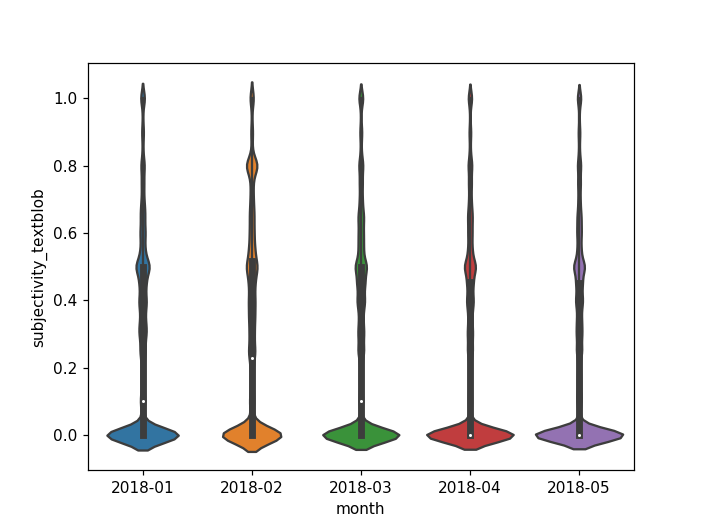

In [17]:
import seaborn as sns
%matplotlib notebook
sns.violinplot(data=eth_tweets_ss.sort_values("month"),
                x="month",
                y="subjectivity_textblob",
                      )

In [ ]:
daily_sentiment_avg.filter("month > '2017-12-30'")\
                    .groupBy("month").count().show()

In [18]:
daility_sentiments = daily_sentiment_avg.withColumn(
                            "month",
                            date_format('date','yyyy-MM')
                                )\
                        .filter("month > '2017-10'")\
                        .withColumn("month",col("month").cast("string"))\
                        .toPandas()

In [19]:
import seaborn as sns

<IPython.core.display.Javascript object>


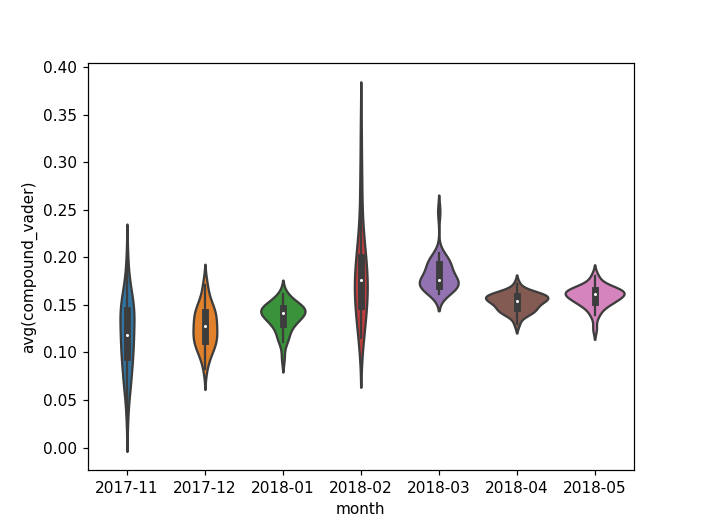

In [20]:
%matplotlib notebook
sns.violinplot(data=daility_sentiments.sort_values("month"),
                x="month",
                y="avg(compound_vader)",
                      )

<IPython.core.display.Javascript object>


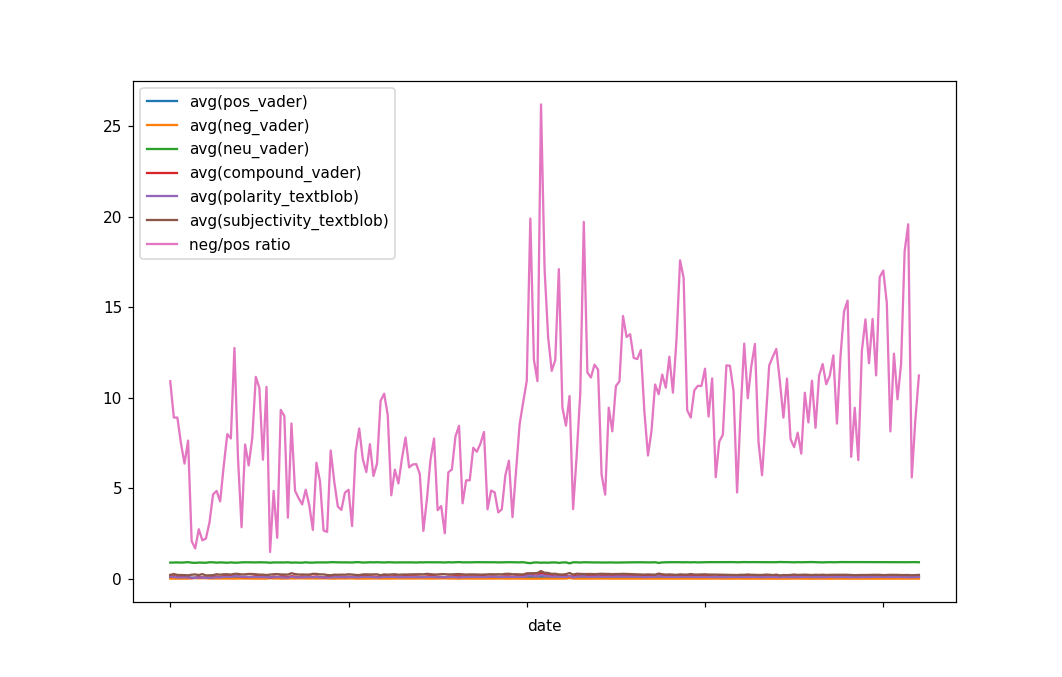

In [21]:
daility_sentiments.sort_values("date").set_index("date").plot(kind="line")

In [ ]:
neutral = (col("compound_vader") >= -0.5) & ( col("compound_vader") <= 0.5 )

In [ ]:
from pyspark.sql.functions import sum, when, count
eth.withColumn(
            "month",
            date_format('datetime','yyyy-MM')
            )\
    .filter("month > '2017-06'")\
    .groupBy("month")\
    .agg(
        avg(when(col("compound_vader") > 0.5, col("compound_vader"))).alias("negative"),
        avg(when(col("compound_vader") < -0.5, col("compound_vader"))).alias("positive"),
        avg("compound_vader"),
        avg(when(neutral, col("compound_vader"))).alias("neurtral"),
        avg("pos_vader"),
        avg("neg_vader")
    )\
    .sort("month")\
    .show()

## BTC

In [6]:
parquet_eth_path = "../data/tweets/bitcoin/parquet/sentiment/"
btc = spark.read.parquet(parquet_eth_path)

In [8]:
btc.count()

26208300

In [7]:
from pyspark.sql.functions import col,date_format,sum
btc.withColumn('date',date_format('datetime','yyyy-MM-dd'))\
.groupby('date')\
.agg(
sum("pos_vader"),
sum("neg_vader"),
sum("neu_vader"),
sum("compound_vader"),
sum("polarity_textblob"),
sum("subjectivity_textblob")
).toPandas()

,date,sum(pos_vader),sum(neg_vader),sum(neu_vader),sum(compound_vader),sum(polarity_textblob),sum(subjectivity_textblob)
0,2017-12-05,5238.976010,2742.208005,75619.917985,6723.675079,7034.917141,20751.347344
1,2017-05-14,1304.482002,591.717001,17421.869999,1598.782689,1442.048681,4515.521104
2,2016-08-17,134.235000,77.044000,1945.723000,131.279199,125.829938,534.484143
3,2017-12-22,9116.197013,6965.945008,135680.906959,5797.436004,8094.050182,37315.314588
4,2017-10-20,2970.793003,1524.102002,45526.125993,3204.167795,3935.993639,12260.049558
5,2017-02-24,1670.979001,678.010002,24050.167001,2082.482002,1950.768820,6319.425354
6,2017-05-11,1549.151003,486.771001,22947.133996,2435.043886,2105.523721,5667.836807
7,2016-04-22,2320.245016,584.677001,22039.112974,4189.293596,1206.227906,5895.690492
8,2016-09-11,1023.608001,424.994001,12414.431999,1218.553394,1175.710745,3079.694825
9,2016-08-08,501.182002,366.793998,7759.046994,181.379708,437.350900,1796.229714


# Reddit

In [41]:
parquet_reddit_path = "../data/reddit-crypto/parquet/sentiment/"
redd = spark.read.parquet(parquet_reddit_path)

In [99]:
redd.limit(4).toPandas()

,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,...,subreddit,ups,distinguished,author_flair_css_class,pos_vader,neg_vader,neu_vader,compound_vader,polarity_textblob,subjectivity_textblob
0,He's joking. Are people really *this* serious ...,None,None,None,Mbizzle135,None,None,2016-09-15 11:24:13,t5_2si5v,t3_52v0z8,...,btc,10,None,None,0.059,0.098,0.843,-0.2682,0.051768,0.416414
1,Did you read the whole OP? Because this ignore...,None,None,None,ForkiusMaximus,None,None,2016-06-08 06:13:32,t5_2si5v,t3_4mzm94,...,btc,9,None,None,0.000,0.116,0.884,-0.5537,0.014583,0.397917
2,I find it hard to believe that something like ...,None,None,None,Harbingerx81,None,None,2016-04-01 15:34:49,t5_2si5v,t3_4cutaf,...,btc,11,None,None,0.157,0.088,0.755,0.2732,-0.291667,0.541667
3,This whole sub is like an eposide of Colbert R...,None,None,None,pizzaface18,None,None,2016-02-17 04:57:41,t5_2si5v,t3_465zpe,...,btc,-36,None,None,0.112,0.129,0.759,-0.1027,0.033333,0.633333


In [134]:
from pyspark.sql.functions import col,date_format,avg, col


redd_daily_sentiment_avg = redd.withColumn('date',date_format('created_utc','yyyy-MM-dd'))\
.groupby('date')\
.agg(
avg("pos_vader"),
avg("neg_vader"),
avg("neu_vader"),
avg("compound_vader"),
avg("polarity_textblob"),
avg("subjectivity_textblob"),
count(when(col("compound_vader") > 0.5, col("compound_vader"))).alias("negative"),
count(when(col("compound_vader") < -0.5, col("compound_vader"))).alias("positive"),
)\
.withColumn(
            "month",
            date_format('date','yyyy-MM')
            )\
.withColumn(
            "pos/neg ratio",
            col("positive")/col("negative")
            )\
.drop("negative","positive")

In [135]:
redd_daility_sentiments = redd_daily_sentiment_avg.withColumn(
                            "month",
                            date_format('date','yyyy-MM')
                                )\
                        .filter("month > '2017-10'")\
                        .withColumn("month",col("month").cast("string"))\
                        .toPandas()

http://brenda.moon.net.au/2012/10/18/pandas-timeseries-plot-setting-x-axis-major-and-minor-ticks-and-labels/

/home/jeroens/miniconda3/envs/pyspark/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


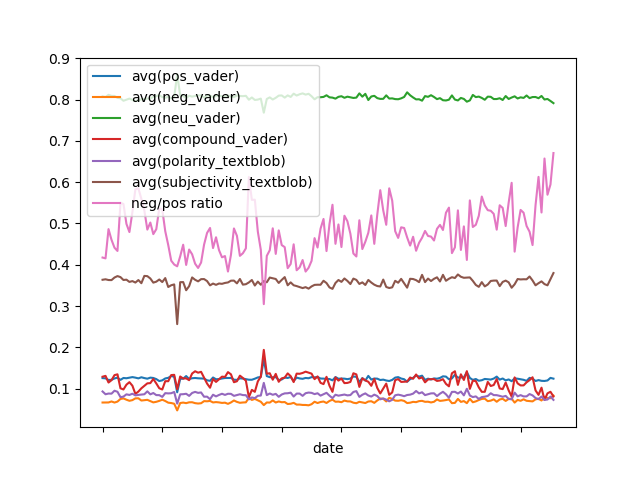

In [170]:
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)

ax = plt.axes()
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)


redd_daility_sentiments.sort_values("date").set_index("date").plot(kind="line")



#x= plt.xticks(redd_daility_sentiments.sort_values("date").index, redd_daility_sentiments.sort_values("date").date, rotation=90)

<IPython.core.display.Javascript object>


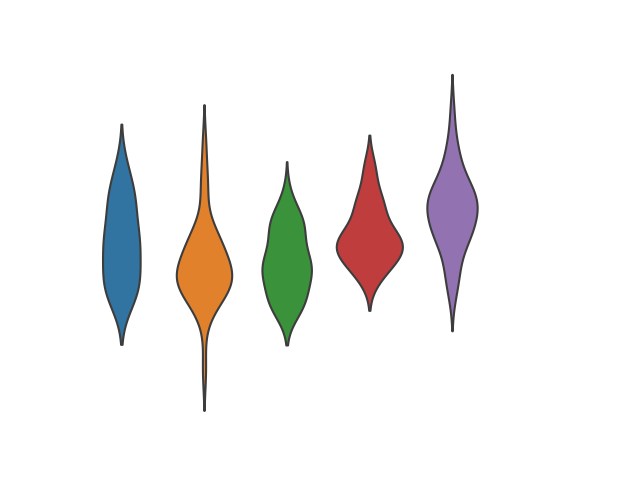

In [154]:
%matplotlib notebook
sns.violinplot(data=redd_daility_sentiments.sort_values("month"),
                x="month",
                y="neg/pos ratio",
                      )

In [141]:
redd_daility_sentiments.dtypes

date                           object
avg(pos_vader)                float64
avg(neg_vader)                float64
avg(neu_vader)                float64
avg(compound_vader)           float64
avg(polarity_textblob)        float64
avg(subjectivity_textblob)    float64
month                          object
neg/pos ratio                 float64
dtype: object

# other 
=

In [6]:
eth.printSchema()

root
 |-- username: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- text: string (nullable = true)
 |-- retweets: integer (nullable = true)
 |-- favorites: integer (nullable = true)
 |-- geo: string (nullable = true)
 |-- mentions: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- pos_vader: float (nullable = true)
 |-- neg_vader: float (nullable = true)
 |-- neu_vader: float (nullable = true)
 |-- compound_vader: float (nullable = true)
 |-- polarity_textblob: float (nullable = true)
 |-- subjectivity_textblob: float (nullable = true)



In [7]:
from pyspark.sql.functions import col

In [93]:
pos = (col("compound_vader") < -0.5) 
x= redd.filter("subreddit == 'ethereum'").filter(pos).limit(45)

In [94]:
redd.select("subreddit").distinct().show()

+---------+
|subreddit|
+---------+
|ethtrader|
|      btc|
|  Bitcoin|
| ethereum|
+---------+



In [95]:
x.select("body","compound_vader","score").limit(50).toPandas()

,body,compound_vader,score
0,I agree.\n\nAdditionally I simply find it a shame how recklessly people are willing to throw away all the core principles Ethereum was created on/for. How many devs will now need to search for another platform because they simply can't rely on their smart contracts being immutable?\n\nWhen will the next hacked DAPP be forked off? When will the first controversial DAPP be forked off? When will users start suing devs because they don't code up a fork for a hacked DAPP because they themselves weren't invested in it and it is too small for them to care?\n\nThis fork is largely based on greed and greed makes blind. Sad to see Ethereum take this path.\n,-0.9211,38
1,"Hello Alex,\n\nYes, we initially thought of such a solution, but we discarded it because it is much more complicated for the end user. It is possible for example that the user has no ETC in the account and the transaction would fail. \nWe would rather not have a contract that relies on the replay attack.\nThat is why we decided to have two separate contracts each fulfilling its own (different) functionality in its respective chain.",-0.8625,11
2,"Lesson to learn? Breaking a system invariant might seem harmless at first, but can backfire in very nasty ways.",-0.7040,14
3,"&gt; Block 1920000 should be around the 20th of July in the morning (UTC time)\n\nThat's rather soon. Will everyone be able to upgrade in time to avoid potential loss of funds?\n\nAnd don't you need to still demonstrate and point to a clear signal of consensus?\n\nIt took Bitcoin almost a year [to do so](https://bitcoin.org/en/bitcoin-core/capacity-increases), and that was for a soft fork. Will you be able to in time?",-0.6531,-5
4,"Except if my business isnt working, my clients will switch to a different business with the possibility of never coming back please keep your retarded offtopic puke of a rotten brain out of this",-0.9074,-7
5,"This is bullshit, frankly. Solidity allows you to write dumb code that does dumb things, and there's a particularly sharp edge that you can cut yourself on where it lets you call out to other contracts. That's it. This is not a bug. This is exactly how Solidity is designed to work.\n\nThat said, the sharp edge described here is real, and is basically a variant of a re-entrant bug.",-0.9100,14
6,"So what if a government buys 10% of Eth, would you need to fork again? If 5% of Eth breaks POS, then it's a bad protocol in the first place.",-0.5423,9
7,All they do is bitch about /r/bitcoin,-0.5859,10
8,Shit is getting real.,-0.5574,13
9,"Your analogies are bad. The Ethereum Foundation owns the trademark. It doesn't matter what your opinion is or what you think. If the foundation only recognizes ETH as ""Ethereum"", then ETC is violating their trademark.\n\nIt's not complicated. It's the law.",-0.7949,-4


In [ ]:
x.show()

In [68]:
redd_pos_pd[["body","compound_vader"]]

,body,compound_vader
0,"Did you read the whole OP? Because this ignores the other half of /u/ydtm's point, which is that Core has *also* refused to raise the blocksize cap, thus forcing *all* normal transactions (not just micro-transactions) off chain.",-0.5537
1,This what happens when barbarians attack.\n\nWhere is your Kalesi? Someone needs to keep you fools in line.,-0.7430
2,Strictly banned? What about this story?\n\nhttps://www.reddit.com/r/Bitcoin/comments/4k47rq/coinbase_exchange_to_rebrand_following_launch_of/\n\nAnd what - we're not allowed to gloat?,-0.5484
3,You mean that economics applies to crypto? Who would have thought?\n\nI believed that the laws of economics would be suspended if nullc said so...../s,-0.5362
4,"&gt; Go suck theymos boots.\n\nI tried doing that here, but maybe I'm doing it wrong?\n\n* https://www.reddit.com/r/Bitcoin/comments/3v04pd/can_we_please_have_a_civil_discussion_about/cxl3et2",-0.7269
5,Why are we hyping so much about halving? \n\nSick of seeing this as some sort of celebration,-0.5106
6,"WTF? By forking, we have proven that this is how bitcoin can be manipulated.",-0.7983
7,Why you don't put the B sign on that rocket? The $ sign will be obsolete soon and is not a sign for profit anymore.,-0.5583
8,"Always good to have someone who has simple and popular answers to complex problems, thanks Roger! Make Bitcoin great again! \n\nEDIT: I tried hard to troll r/btc with this one, but I failed miserably due to low IQ levels here.",-0.8193
9,&amp;nbsp;* cough *\n\n&amp;nbsp; liar.,-0.5106


In [90]:
neurtral = (col("compound_vader") < 0.5) & (col("compound_vader") > -0.5) 

redd_pd = redd.filter(neurtral).limit(5000).toPandas()

In [91]:
import pandas as pd
pd.set_option("max_colwidth",5000)
redd_pd[["body","compound_vader"]]

,body,compound_vader
0,"He's joking. Are people really *this* serious on the Internet the whole time.\n\nEdit; Not to the first part he picked out. It is true SegWit is a misguided and convoluted attempt to scale on chain that brings the possibility of a double spend to the masses, and is a controversial change that's being forced down our throats as a soft fork rather than allowing a vote through Nakamoto consensus, as would be the case with a hard fork.",-0.2682
1,I find it hard to believe that something like this would be used as a 'joke'.,0.2732
2,This whole sub is like an eposide of Colbert Report. I can't tell if most comments are satire or stupidity.,-0.1027
3,Great job core! The 5 percent tyrannise the 95 percent. \nFor how much more time do you children think you can fool the majority?\n6 months? 6 years?,0.4646
4,"To reduce confusion and offer people a common language and reference point, I've summarized the main on-chain scalability proposals in this blog post. \n\nI think its pretty comprehensive for an evening's work but please help me by commenting on omissions, inaccuracies, confusing language, adding links etc. Some links are paradoxically hard -- Seg Wit for example has so much discussion I am having trouble finding a authoritative reference.",0.2500
5,That's not what he said.,0.0000
6,[deleted],0.0000
7,This video is nonsense.,-0.4019
8,r/bitcoin is over...,0.0000
9,"And this is supposed to be ""easier"", ""safer"", and ""faster"" than just doing a simple hard fork capacity increase. yep..",0.2263


In [92]:
redd_pd

,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,...,subreddit,ups,distinguished,author_flair_css_class,pos_vader,neg_vader,neu_vader,compound_vader,polarity_textblob,subjectivity_textblob
0,"He's joking. Are people really *this* serious on the Internet the whole time.\n\nEdit; Not to the first part he picked out. It is true SegWit is a misguided and convoluted attempt to scale on chain that brings the possibility of a double spend to the masses, and is a controversial change that's being forced down our throats as a soft fork rather than allowing a vote through Nakamoto consensus, as would be the case with a hard fork.",None,None,None,Mbizzle135,None,NaN,2016-09-15 11:24:13,t5_2si5v,t3_52v0z8,...,btc,10,None,None,0.059,0.098,0.843,-0.2682,0.051768,0.416414
1,I find it hard to believe that something like this would be used as a 'joke'.,None,None,None,Harbingerx81,None,NaN,2016-04-01 15:34:49,t5_2si5v,t3_4cutaf,...,btc,11,None,None,0.157,0.088,0.755,0.2732,-0.291667,0.541667
2,This whole sub is like an eposide of Colbert Report. I can't tell if most comments are satire or stupidity.,None,None,None,pizzaface18,None,NaN,2016-02-17 04:57:41,t5_2si5v,t3_465zpe,...,btc,-36,None,None,0.112,0.129,0.759,-0.1027,0.033333,0.633333
3,Great job core! The 5 percent tyrannise the 95 percent. \nFor how much more time do you children think you can fool the majority?\n6 months? 6 years?,None,None,None,Zarathustra_III,None,NaN,2016-02-22 10:56:47,t5_2si5v,t3_46ywkk,...,btc,14,None,None,0.160,0.094,0.746,0.4646,0.750000,0.625000
4,"To reduce confusion and offer people a common language and reference point, I've summarized the main on-chain scalability proposals in this blog post. \n\nI think its pretty comprehensive for an evening's work but please help me by commenting on omissions, inaccuracies, confusing language, adding links etc. Some links are paradoxically hard -- Seg Wit for example has so much discussion I am having trouble finding a authoritative reference.",None,None,None,thezerg1,Andrew Stone - Bitcoin Unlimited Lead Dev,NaN,2016-03-09 19:01:06,t5_2si5v,t3_49oyvb,...,btc,11,None,btcdev,0.134,0.121,0.745,0.2500,-0.021875,0.509375
5,That's not what he said.,None,None,None,sqrt7744,None,NaN,2016-01-02 09:33:45,t5_2si5v,t3_3z26q2,...,btc,10,None,None,0.000,0.000,1.000,0.0000,0.000000,0.000000
6,[deleted],None,None,None,[deleted],None,NaN,2016-02-04 13:35:24,t5_2si5v,t3_443ohv,...,btc,-5,None,None,0.000,0.000,1.000,0.0000,0.000000,0.000000
7,This video is nonsense.,None,None,None,Rf3csWxLwQyH1OwZhi,None,NaN,2015-12-15 11:36:49,t5_2si5v,t3_3wwyt7,...,btc,10,None,None,0.000,0.474,0.526,-0.4019,0.000000,0.000000
8,r/bitcoin is over...,None,None,None,BitWhisky,None,NaN,2016-07-21 11:50:02,t5_2si5v,t3_4tute9,...,btc,9,None,None,0.000,0.000,1.000,0.0000,0.000000,0.000000
9,"And this is supposed to be ""easier"", ""safer"", and ""faster"" than just doing a simple hard fork capacity increase. yep..",None,None,None,cryptonaut420,None,NaN,2016-01-18 23:36:28,t5_2si5v,t3_41ksns,...,btc,29,None,None,0.111,0.068,0.821,0.2263,-0.145833,0.449405
